<div>
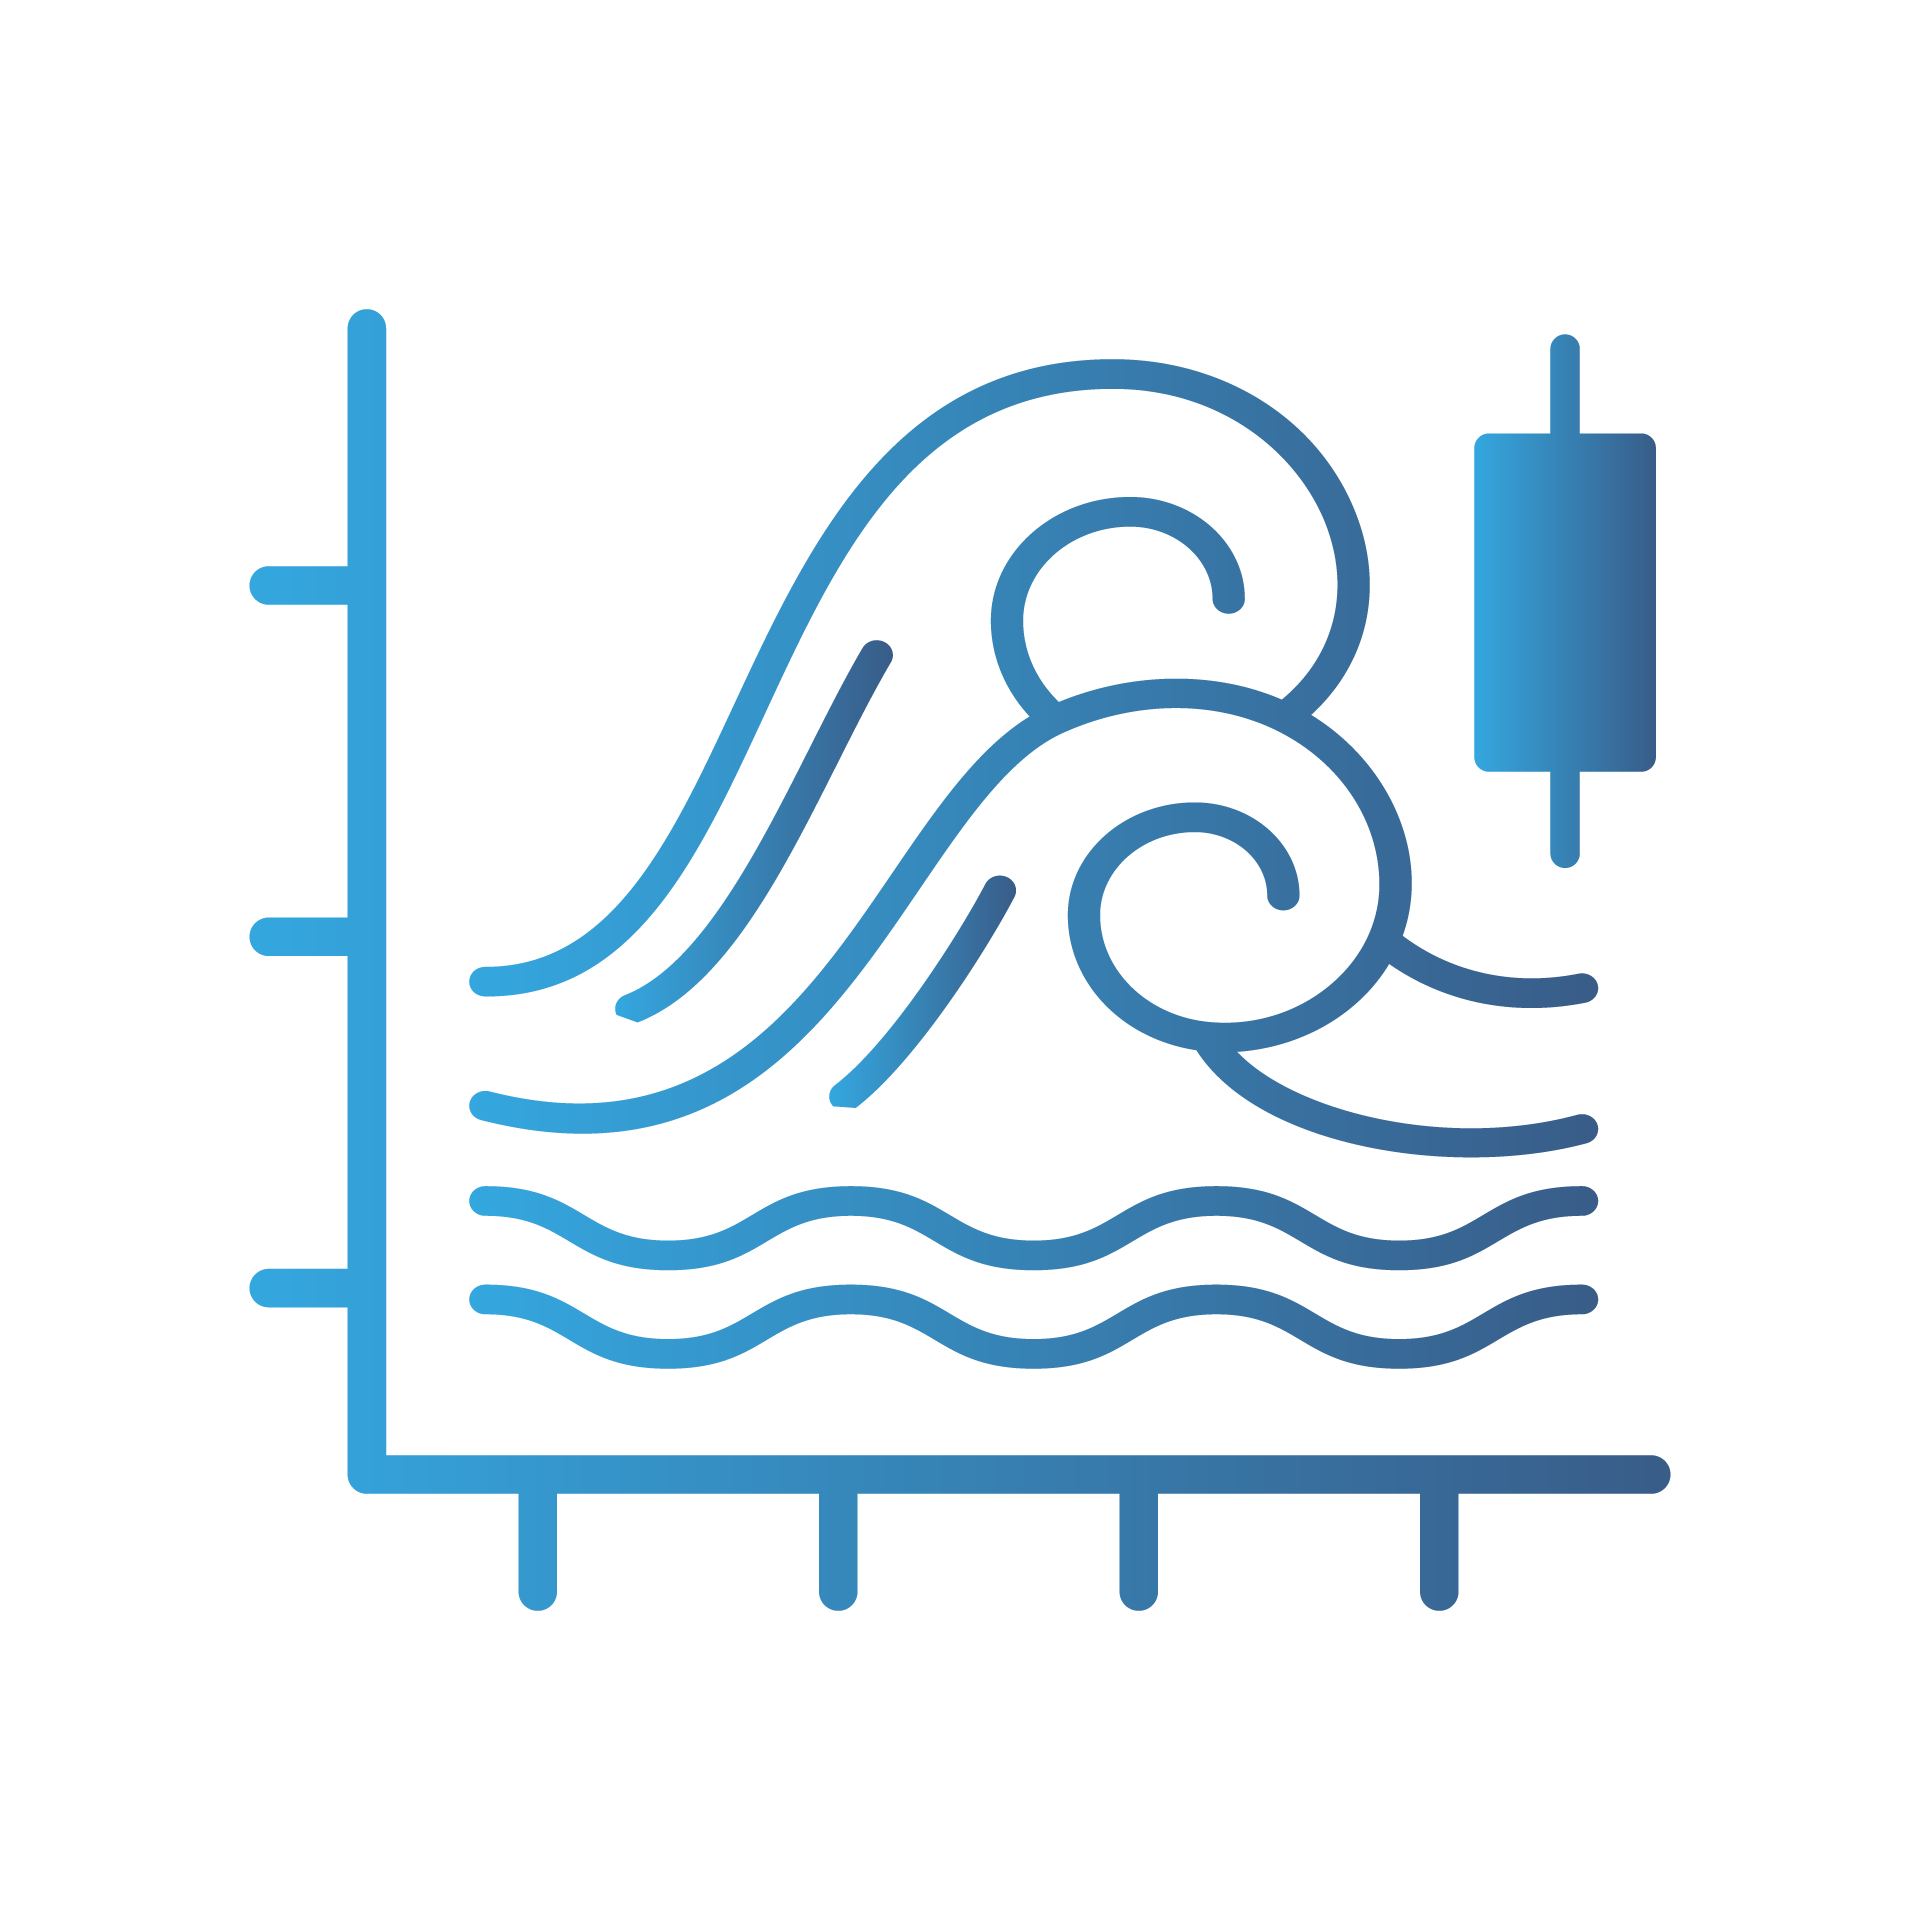
</div>

# __Predict labels with a PCM model and plot results__

The objective of this notebook is to load a PCM model, classify some data into clusters (prediction) and plot the results.

A PCM (__Profile Classification Model__) allows to automatically, without supervision, assemble ocean profiles into clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the ocean patterns indicators, and they will be presented through different plots. For more information about the method, [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a selection of GLOBAL_REANALYSIS_PHY_001_030 CMEMS product covering the Mediterranean is used as an input dataset.

In this notebook we're going to load an existing classification model. You can develop, train and optimize a model of your own using the notebook Develop_PCM_model.ipynb.

Computation is done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)

This notebook have been developped by Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409


<div>
<center>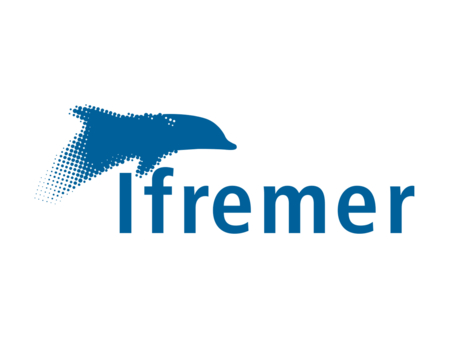 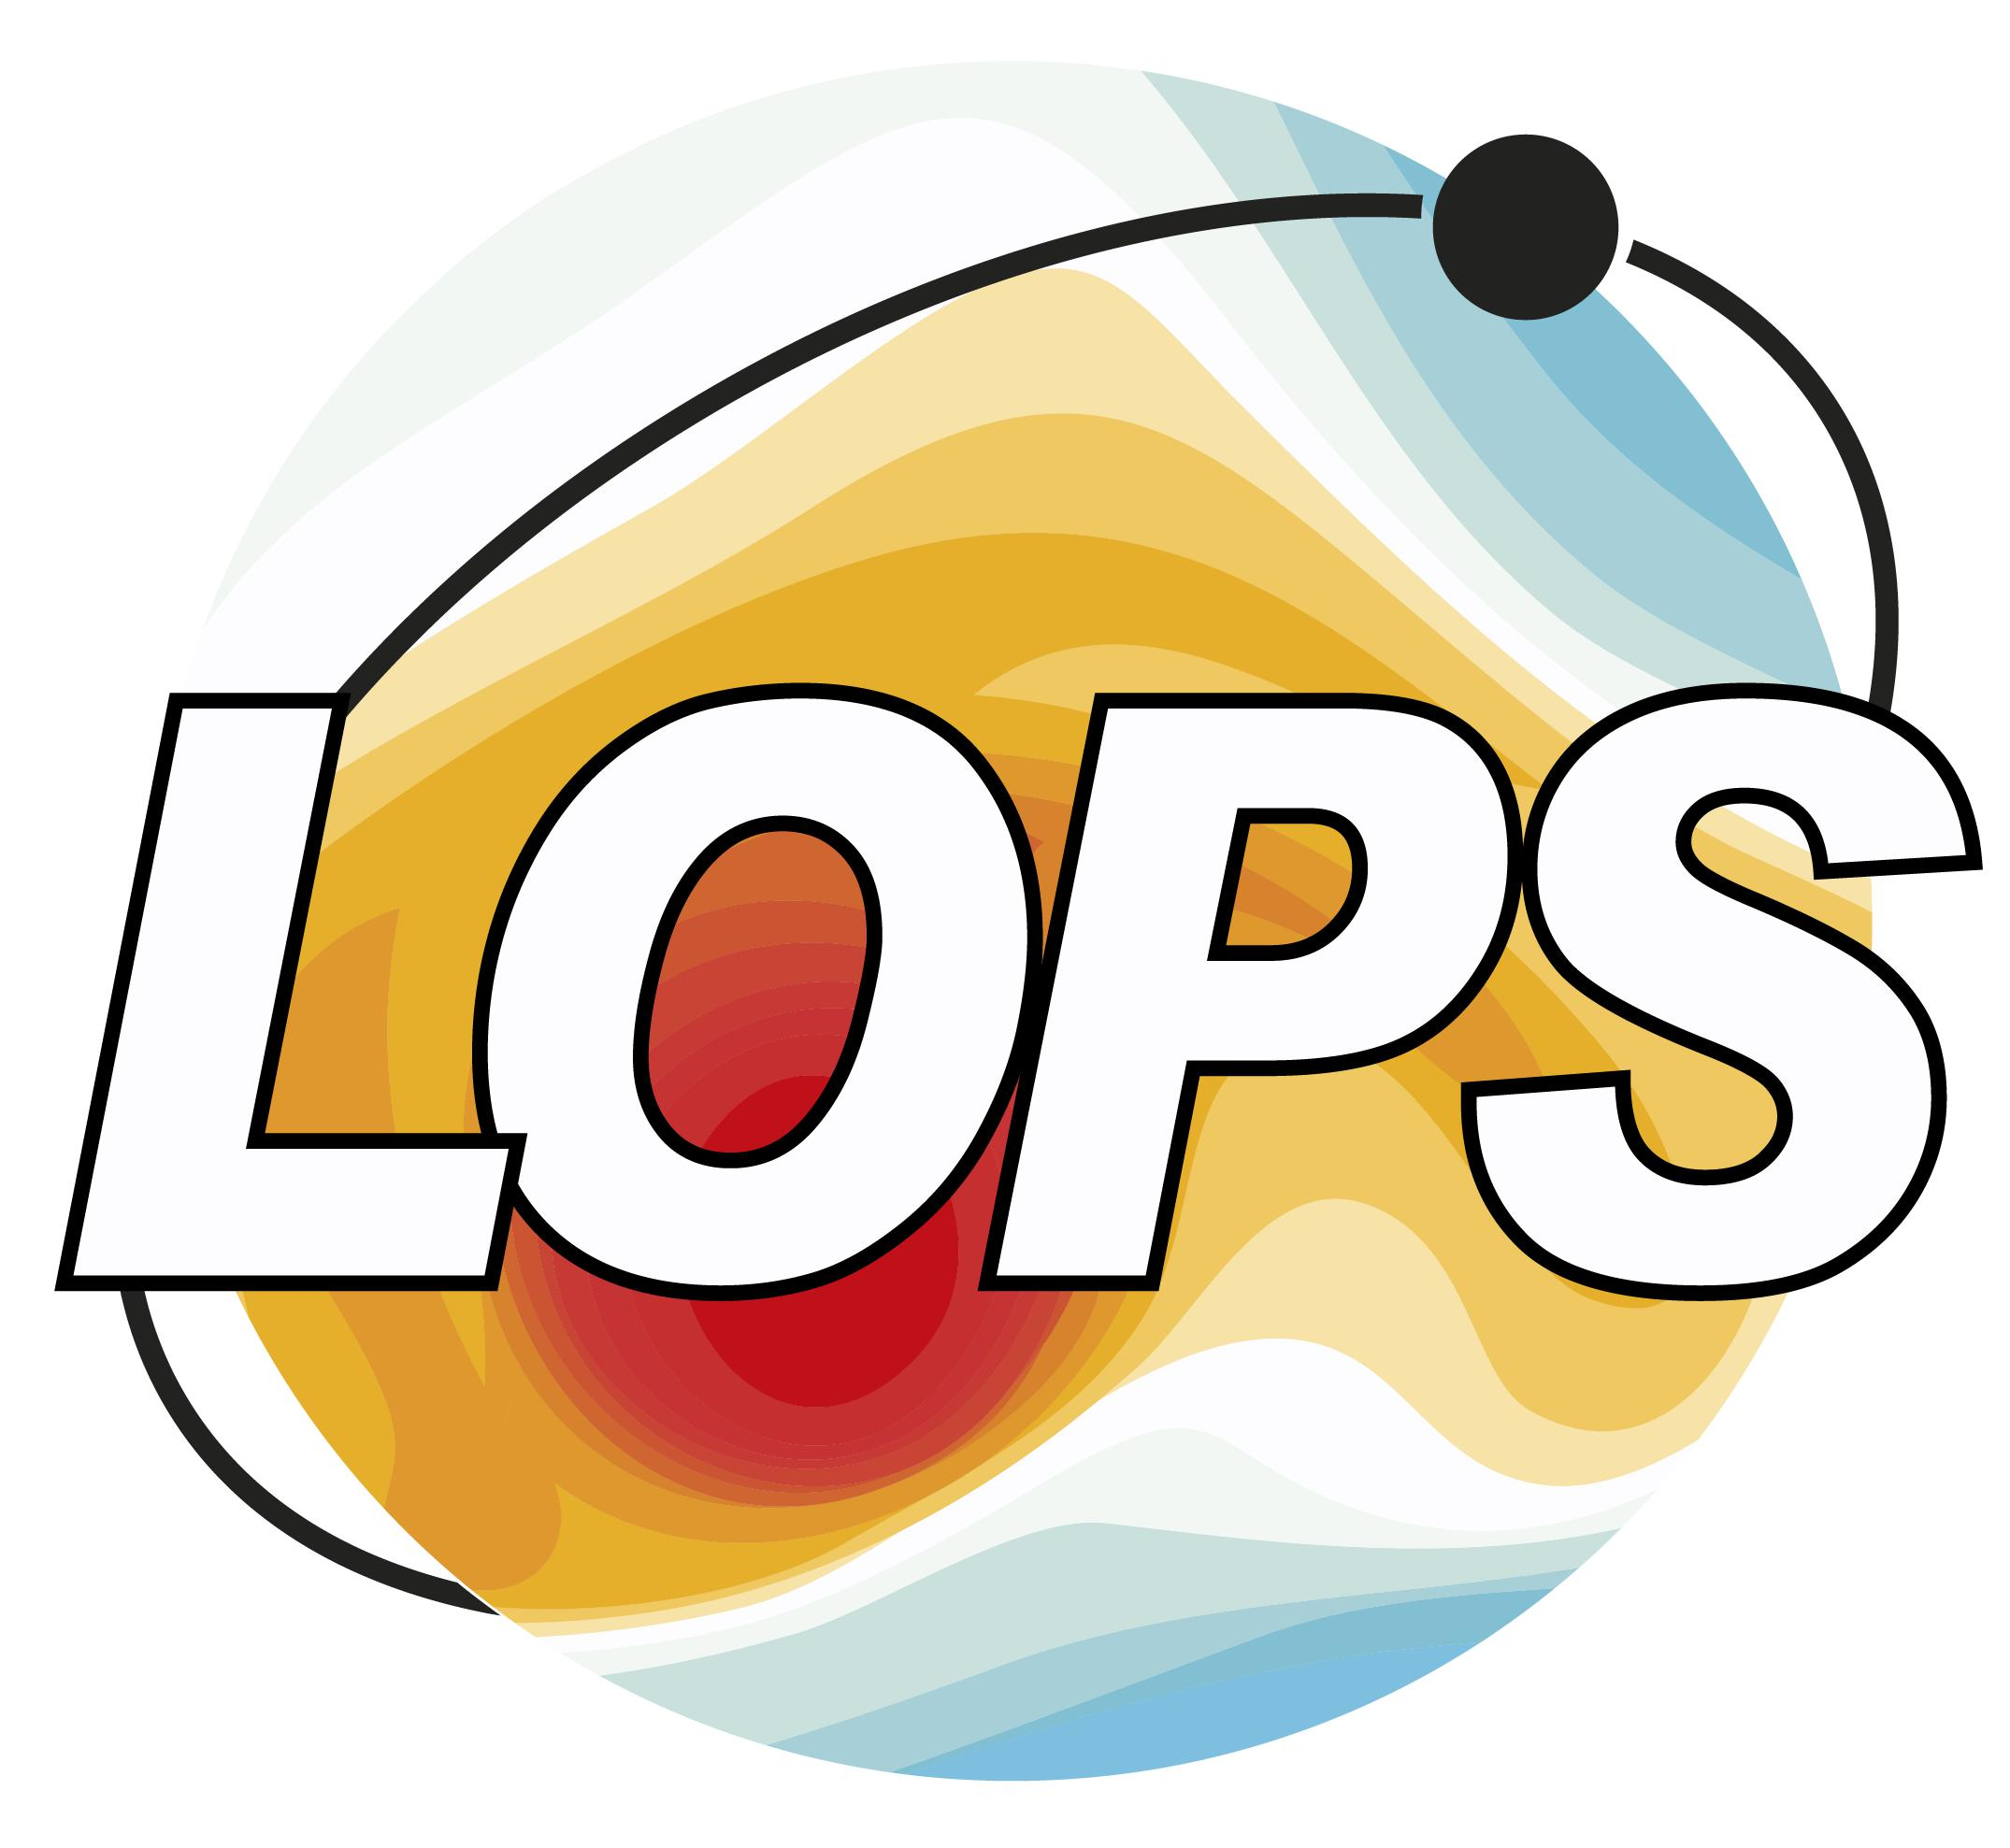 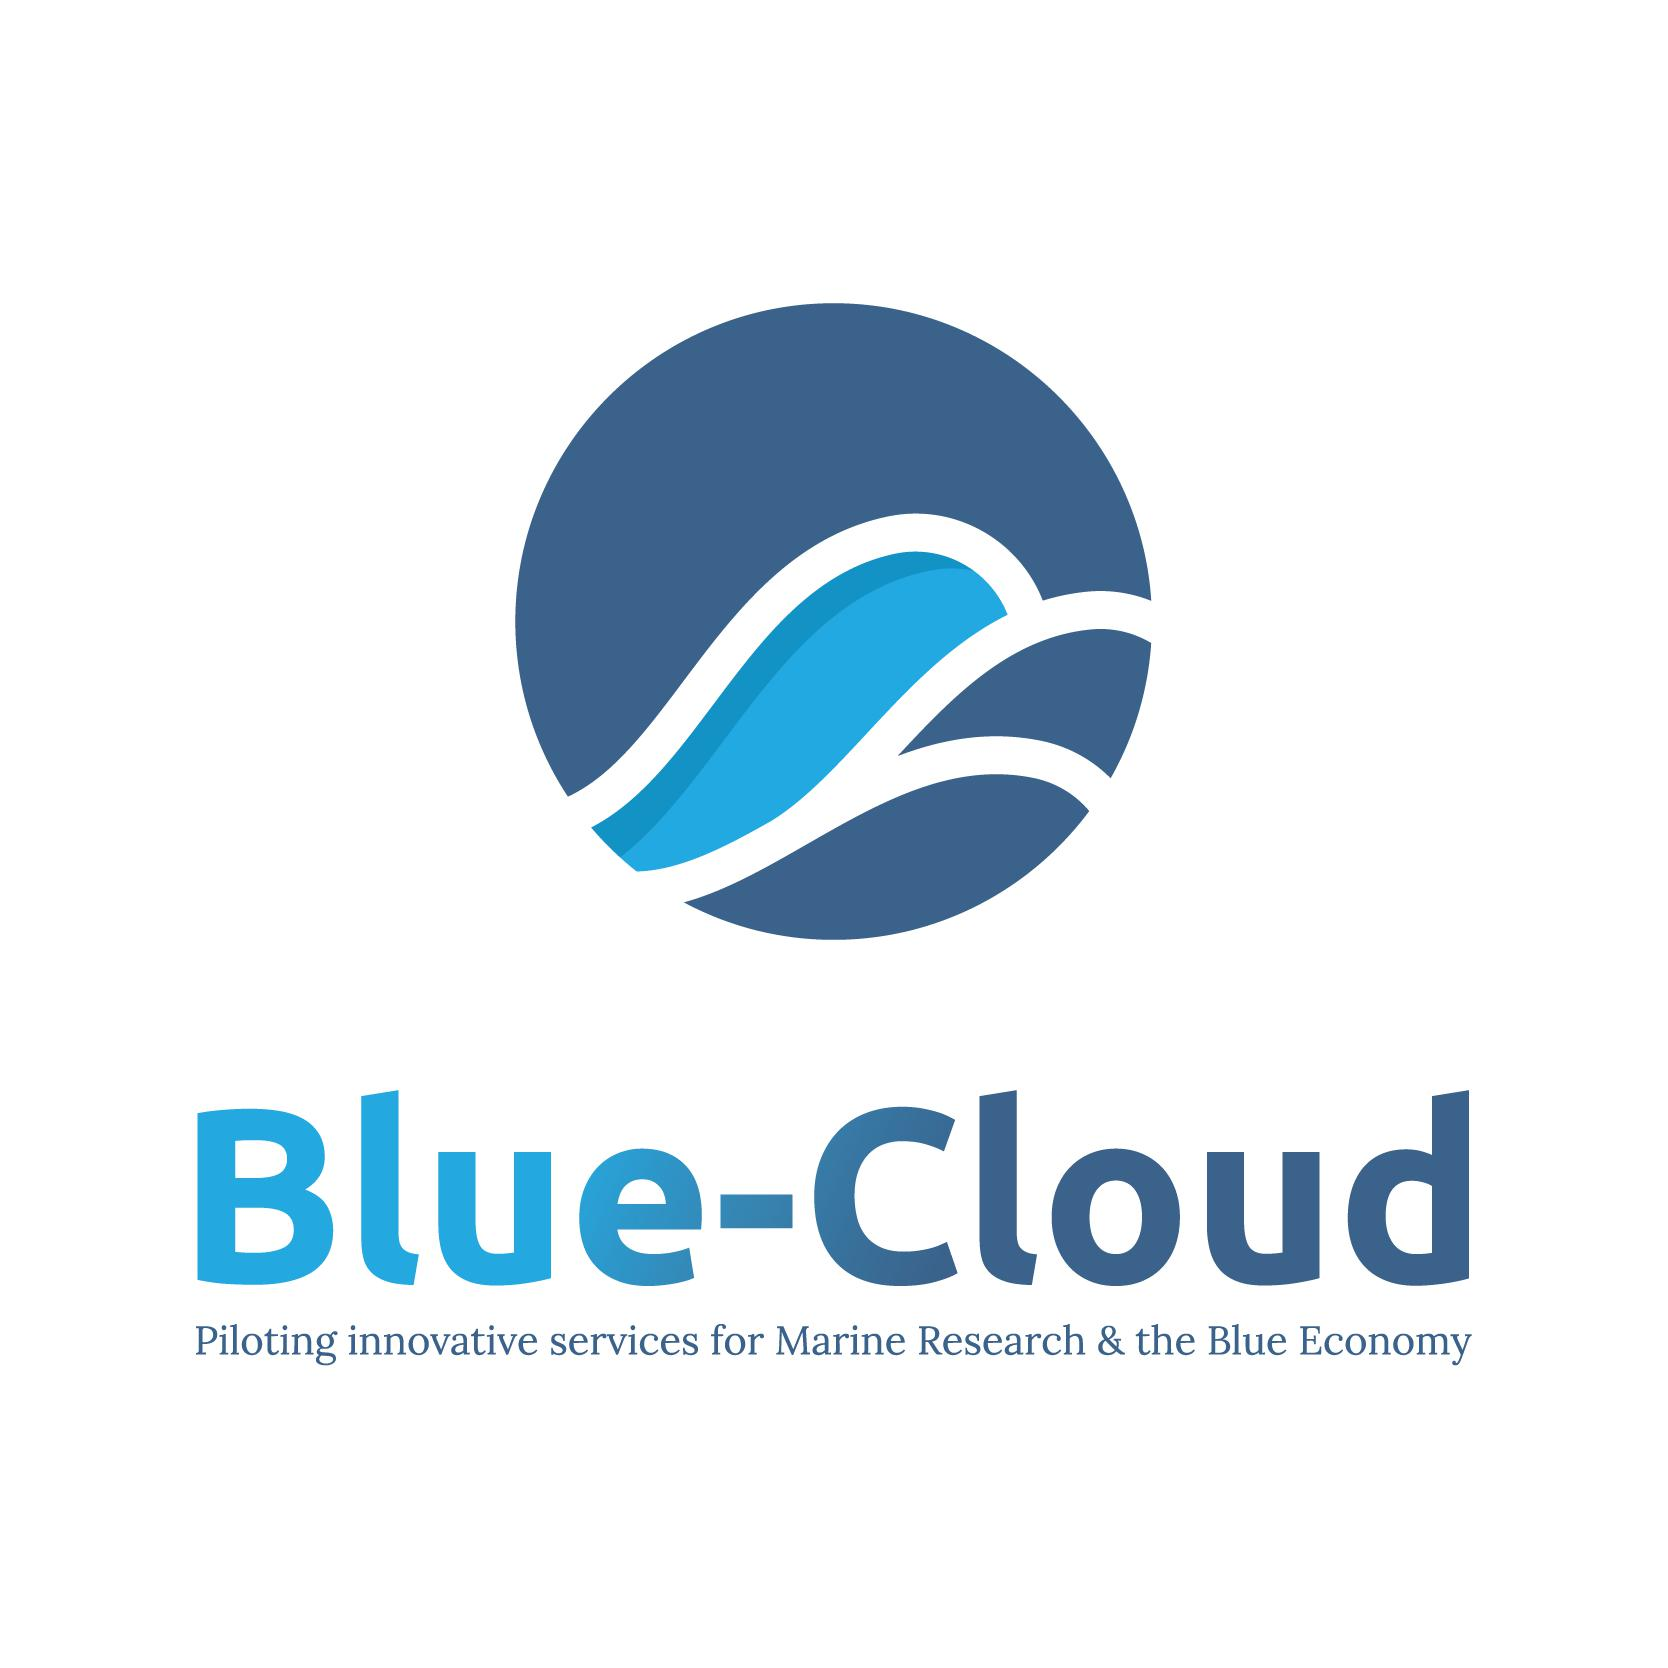</center>
</div>

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

import subprocess

## Load model and dataset
***

In this section you will upload the __model__ and the __dataset__ and you should provide some information about them. 

You don't need to use the same dataset you used to train the model for making the prediction of labels. You can, for example, train the model with in-situ data and apply it to a numerical model dataset in order to evaluate the numerical model realism.

__Load model__

You can choose an already trained model, available for you in *models/* folder, or you can design your own model using the *Develop_PCM_model.ipynb* notebook. 

In the cell below you should provide tho model path and the name in the model of the variable (feature) to be predict.

In [2]:
# Model path
model_path = 'models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc'

# Variable to be predict
var_name_mdl = 'temperature' # name in model

*pyxpcm* library is used to load the chosen model.

In [3]:
m = pyxpcm.load_netcdf(model_path)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 43.932334

__Load dataset__

Dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [4]:
CMEMS_user = 'agarcia6'
CMEMS_password = '1802910672Aa#'

Data comes from monthly mean fields of *GLOBAL_REANALYSIS_PHY_001_030* product, an eddy-resolving reanalysis with 1/12° horizontal resolution and 50 vertical levels (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030) for getting all the infomation about the dataset). As an example, we propose to you a selection covering the Mediterranean sea during 2018.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables, but do not forget to choose the good model to fit the data. And be careful with memory limits: do not choose very big geographical extents or very long time series.

In [5]:
# geographical extent
geo_extent = [-5, 35, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2018-01-01", "2018-12-31"] # ["min date", "max_date"]
# variable to be predict
var_name_ds = 'thetao' # name in dataset

Dataset is download from __CMEMS__ servers using a Motu client and saved as a __NetCDF__ file in *datasets/* folder in your work space. Downloading will take some minutes.

In [6]:
!pip install motuclient --upgrade
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v so -v ' + var_name_ds + ' -o datasets -f global-reanalysis-phy-001-030-monthly_med.nc'
sp = subprocess.call(bashCommand, shell=True)
file_path = 'datasets/global-reanalysis-phy-001-030-monthly_med.nc'

Finally, the dataset is load from the NetCDF file using *xarray* library.

In [7]:
ds = xr.open_dataset(file_path)

# some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'
z_dim = 'depth'

print(ds)

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 193, longitude: 481, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -1941.893 -2225.078
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 45.916668 46.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -5.0 -4.9166665 -4.8333335 ... 34.916668 35.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitori

Quick plot of dataset. Please, choose time and depth slide if needed.

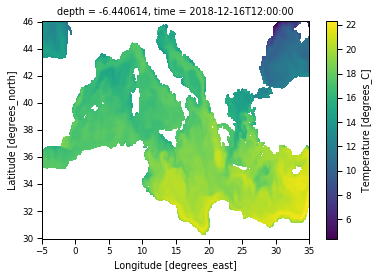

In [8]:
ds[var_name_ds].isel(time=11, depth=5).plot();

## Predict labels
***

Classes labels and some statistics are computed using *pyxpcm* library. New variables with the results are added to the dataset (`inplace=True` option).

__Predict class labels__

Taking into account the characteristics of the classes already determine in the trained model, each profile in the dataset is classified (__predicted__) into one of the classes. A new variable *PCM_LABELS* is created, including one class label for each profile.

In [9]:
features_in_ds = {var_name_mdl: var_name_ds}
m.predict(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Probability of a profile to be in a class__ (Posteriors)

As *pyxpcm* software is using a GMM (Gaussian Mixture Model) to determine clusters, it is possible to calculate the probability of a profile to belong to a class, also call __posterior__. This is the first step to determine the robustness of the model, that will be calculated below. A new variable *PCM_POST* is created.

In [10]:
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Classes quantiles__

Class vertical structure can be represented using the quantiles of all profiles corresponding to a class. We advise to you to calculate at least the __median profile__ and the 5% and 95% quantiles (`q=[0.05, 0.5, 0.95]`) to have a good representation of the classes, but feel free to add other quantiles if you want. A new variable `outname=var_name_ds + '_Q'` is added to the dataset.

In [11]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds, outname=var_name_ds + '_Q', keep_attrs=True, inplace=True)

__Robustness__

Robustness represents the __probability__ of a profile to belong to a class, as posteriors, but the value range is more appropriated for graphic representation. Two new variables are added to the dataset: *PCM_ROBUSTNESS* and *PCM_ROBUSTNESS_CAT*.

In [12]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 41, latitude: 193, longitude: 481, pcm_class: 8, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7
  * depth               (depth) float32 -0.494025 -1.541375 ... -2225.078
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 45.83 45.92 46.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude           (longitude) float64 -5.0 -4.917 -4.833 ... 34.92 35.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    so                  (time, depth, latitude, longitude) float32 nan ... nan
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan ... nan
    thetao_Q            (pcm_class, quantile, depth) float64 9.251 ... 13.6
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Plot results
***

Plots are created using the *Plotter* class, which is instantiate below. Plots include the vertical structure and the spatial and the temporal distribution of classes. These plots would allow you to determine if classes show a spacial or temporal coherence: the __ocean patterns indicators__.

*save_BlueCloud* function save the figure and add dataset information and logos below. 

Please, feel free to change plot options if you need it.

In [13]:
P = Plotter(ds, m)

#### __1. Vertical structure of classes__

The graphic representation of quantile profiles reveals the vertical structure of each class and how clusters are created, as the clustering method is base on finding similarities in the vertical structure of the feature (profiles). The median profiles will give you an idea of the __typical profile__ representing each class and the rest of quantiles, the __variability__ of the profiles within a class.

Figure saved in figures/vertical_struc_EX.png


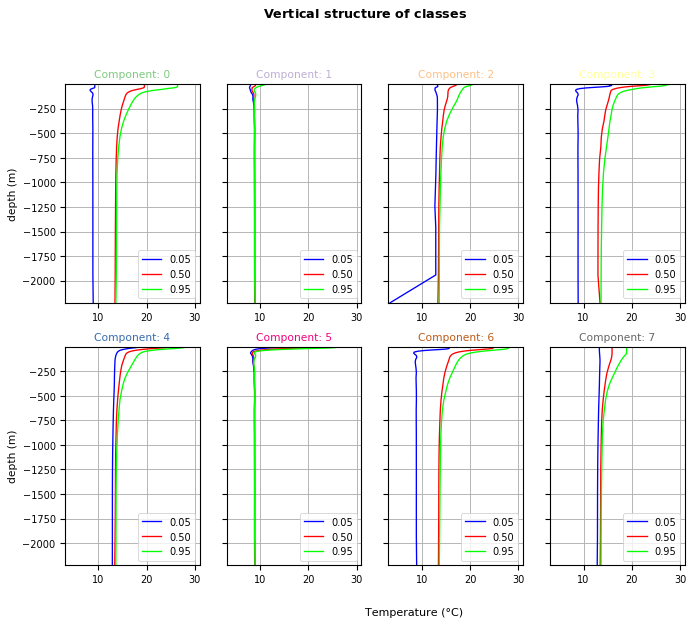

In [14]:
P.vertical_structure(q_variable = var_name_ds + '_Q', sharey=True, xlabel='Temperature (°C)')
P.save_BlueCloud('figures/vertical_struc_EX.png')

Quantile profiles can be also plotted __together__ to show the differences between profiles representing each class. Using `plot_q` option you can choose the quantiles you want to plot together.

Figure saved in figures/vertical_struc_comp_EX.png


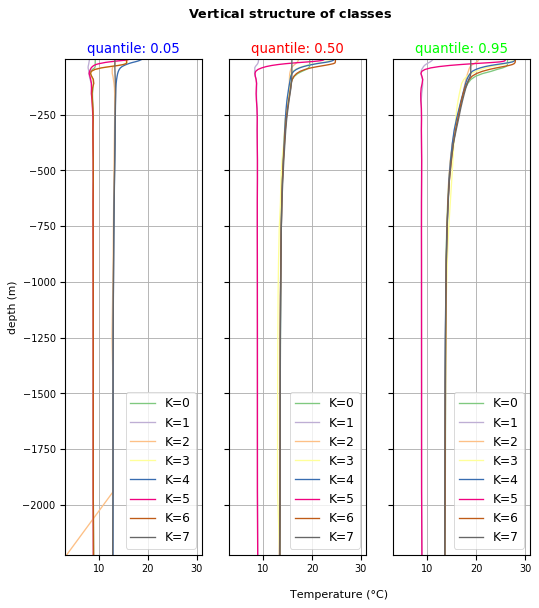

In [15]:
P.vertical_structure_comp(q_variable = var_name_ds + '_Q', plot_q= 'all', xlabel='Temperature (°C)')
P.save_BlueCloud('figures/vertical_struc_comp_EX.png')

#### __2. Spatial distribution of classes__

You can also plot the PCM labels in a map to determine the spatial coherence of classes. The spatial information (coordinates) is not used to fit the model, so spatial coherence appears naturally, reveling vertical structure similarities between different zones. If you detect any spatial coherence, well done, you have found the __ocean patterns indicator__!.

As the dataset is a time series you should choose a time slide using `time_slide` option in the plotting function below.

Figure saved in figures/spatial_distr_EX.png


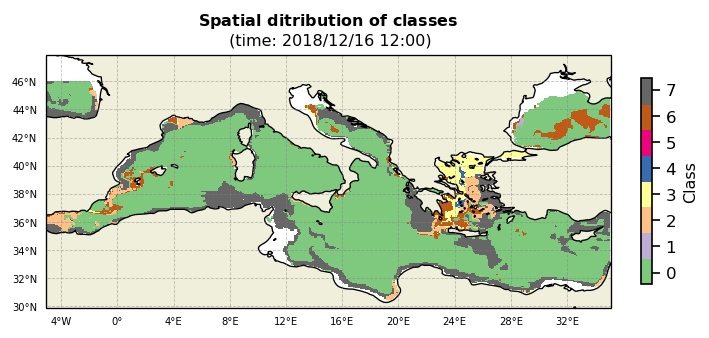

In [16]:
P.spatial_distribution(time_slice="2018-12")
P.save_BlueCloud('figures/spatial_distr_EX.png')

As the example dataset is a time series, you can also plot, for each pixel, the __most frequent class label__, using the option `time_slice='most_freq_label'`. This will give you a general idea of the labels found in the whole time series.

Figure saved in figures/spatial_distr_freq_EX.png


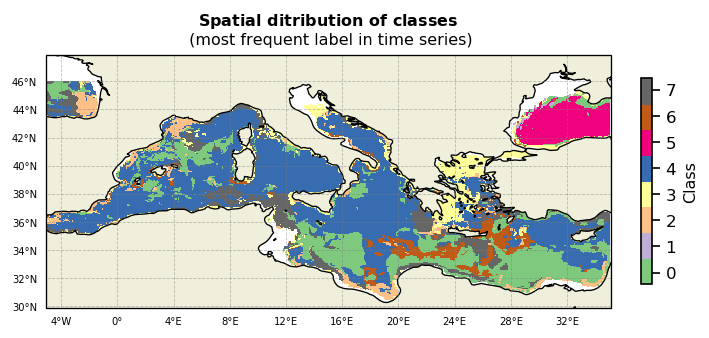

In [17]:
P.spatial_distribution(time_slice='most_freq_label')
P.save_BlueCloud('figures/spatial_distr_freq_EX.png')

#### __3. Robustness__

Robustness represents the __probability__ of a profile to be part of a class. If the probability is very high for all profiles in a class, the class can be consider well delimited or robust. You can also derive conclusion about the transition between classes: if there is a zone with low probability profiles between classes, a smooth transition occurs. You can find an example of this type of analysis for the North Atlantic ocean in [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

You should also chose the `time_slice` option  in the plotting  function below, as example dataset is a time series.

Figure saved in figures/robustness_EX.png


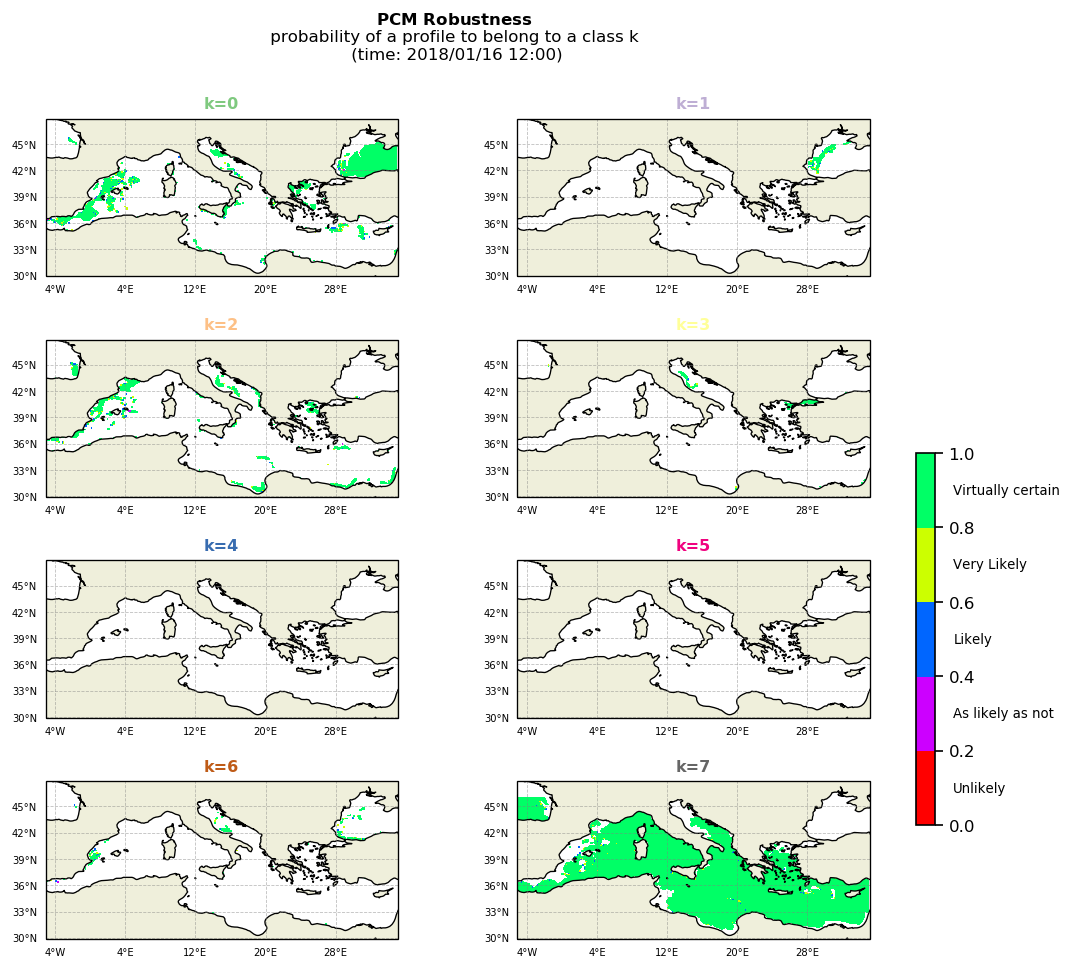

In [18]:
P.plot_robustness(time_slice="2018-01-01")
P.save_BlueCloud('figures/robustness_EX.png')

#### __4. Classes pie chart__

Here you can plot a pie chart showing the percentage of profiles belonging to each class and the number of classified profiles.

Figure saved in figures/pie_chart_EX.png


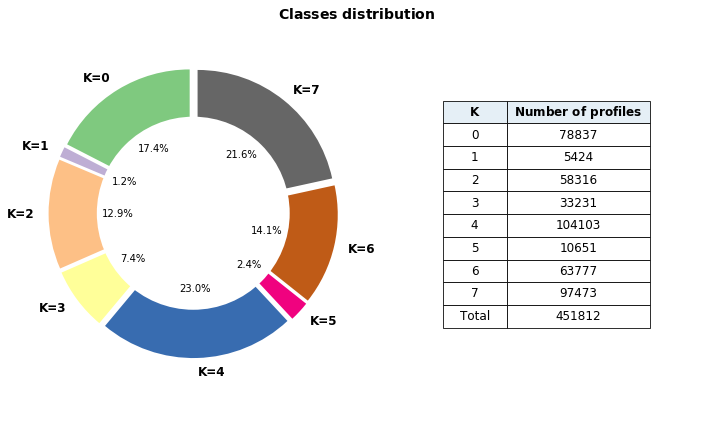

In [19]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')

#### __4. Temporal representation__ 

The bar plots below represent the percentage of profiles in each class by month and by season. These plots can unfold underlying temporal coherence between classes: some classes would be more important in summer or in winter periods. Coherence is revealed naturally as time information is not used for fitting the model. If you find temporal coherence, well done, you have found the __Ocean Patterns Indicator__.

Bar plot by __month__

Figure saved in figures/temporal_distr_months_EX.png


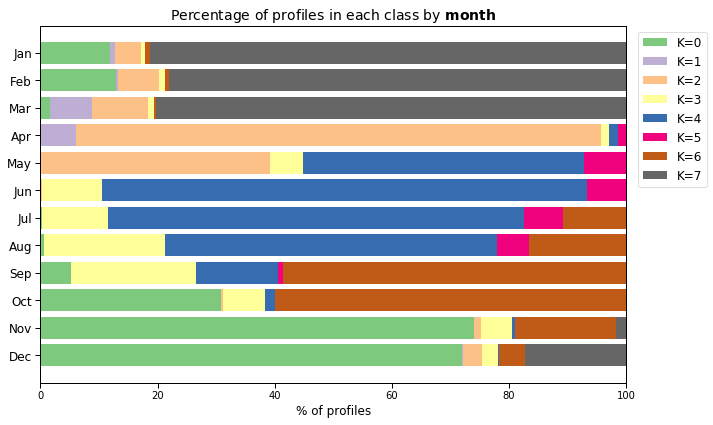

In [20]:
P.temporal_distribution(time_bins = 'month')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __season__

Figure saved in figures/temporal_distr_season_EX.png


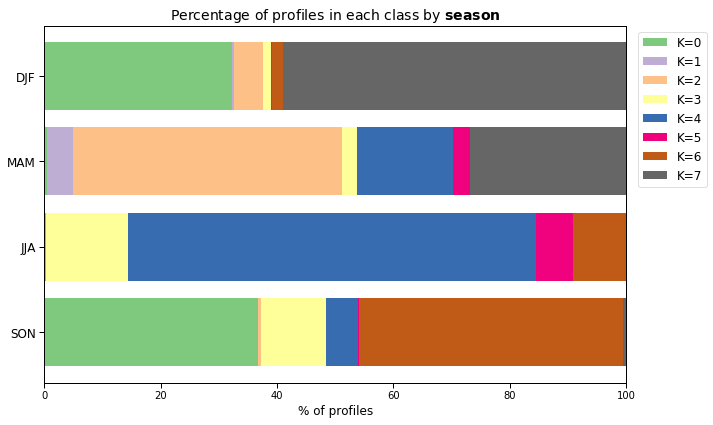

In [21]:
P.temporal_distribution(time_bins = 'season')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')

## Save data
***

If you are happy with the results and you want to work on the data by your own, you can save the dataset including the new PCM variables (PCM labels, robustness, …) in the cell below.

In [23]:
ds.to_netcdf('datasets/tests_predicted_dataset.nc')